In [35]:
import numpy as np
import camb
from matplotlib import pyplot as plt
import scipy.constants as const

In [3]:
#cosmic model 
def get_spectrum(pars,data_lenght,lmax=3000):
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3] 
    As=pars[4]
    ns=pars[5]

    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt[2:][:data_lenght]

In [4]:
#We use this to compute the Jacobian 
#It uses the central difference method
def central_diff(fun,pars,dp,x):

    data_lenght = len(x)

    #Initialzaing the A
    A=np.empty([data_lenght,len(pars)])

    #We want the partial with respect to each parameter
    #So we loop over each parameter
    for i in range(len(pars)):
        p_copy=pars.copy() #copying the paramater array 

        #Foward step f(x+dx)
        p_copy[i]=pars[i]+dp[i]
        foward_step=fun(p_copy,data_lenght)

        #Backward step f(x-dx)
        p_copy[i]=pars[i]-dp[i]
        backward_step=fun(p_copy, data_lenght)

        #Central difference
        A[:,i]=(foward_step-backward_step)/(2*dp[i])
    return A

In [5]:
#This perfroms Gauss-Newton method
def newton(fun,pars,N_inv,dp,x,y,niter=20):

    data_lenght = len(x)

    for i in range(niter):

        #Coputing residuals
        pred=fun(pars,data_lenght)
        r=y-pred

        #Compute Jacobian
        J=central_diff(fun,pars,dp,x)

        #The next step is equal to (J^T*N*J)*(J^T*N*resdiuals)^-1
        #As seen in class
        lhs=J.T@N_inv@J
        rhs=J.T@N_inv@r
        cov = np.linalg.inv(lhs)
        step=cov@rhs

        #Increasing parameters by next step 
        pars=pars+step
        
    return pars, cov

In [6]:
#This return the chi square of our model
#provided the parameters 
def chi_sq(parms,errs,y):
    data_lenght = len(y)
    resid = y-get_spectrum(parms, data_lenght)
    return np.sum((resid/errs)**2)

In [7]:
def constraint_chi_sq(parms,errs,y):
    return chi_sq(parms,errs,y)+((parms[3]-0.054)/0.0074)**2

In [8]:
def get_step(L, shape):
        return L@np.random.randn(shape)

In [9]:
def mcmc(fun,running_pars,trial_step,data,err,nstep=20000,T=1):

    #Initializing the arrays that is going to keep 
    # a history of our chain anc chi-square
    chain_history=np.zeros([nstep,len(running_pars)])
    chain_history[0,:]=running_pars #First element is our guess parameters

    chisq_history=np.zeros(nstep)
    running_chi=fun(running_pars,err,data)
    chisq_history[0]=running_chi  #First element is the chi-square evaluated 
    #with our guess parameter


    L=np.linalg.cholesky(trial_step)
    shape = trial_step.shape[0]

    for i in range(1,nstep):

        #Add a step to our parameters using a step maker function
        new_pars=running_pars+get_step(L,shape)

        #Compute chi-square with new parameters 
        new_chi=fun(new_pars,err,data)

        #Check with accept the step using the formula from class
        accept_prob=np.exp(-0.5*(new_chi-running_chi)/T)
        if np.random.rand(1)<accept_prob:
            running_pars=new_pars
            running_chi=new_chi
        
        #If the the step got accepted the next element in our history
        # is the this new step otherwise it's just the previous one 
        chain_history[i,:]=running_pars
        chisq_history[i]=running_chi


    return chain_history,chisq_history

In [10]:
def gaussian(x,mu,sig):
    return 1/np.sqrt(2*np.pi*sig**2)*np.exp(-(x-mu)**2/(2*sig**2))

In [11]:
def dark_energy(pars,errs):
    
    dark_energy = (1 - 100**2/pars[0]**2*(pars[1]+pars[2]))

    d_dh =100**2*2/pars[0]**3*(pars[1]+pars[2])
    d_db = (100/pars[0])**2
    d_dc = (100/pars[0])**2

    
    err = np.sqrt((d_dh*errs[0])**2 + (d_db*errs[1])**2 + (d_db*errs[1])**2)


    return dark_energy, err

In [44]:
def weighted_std(data, weights):
    mean = np.average(data, weights=weights)
    variance = np.average((data-mean)**2, weights=weights)
    return np.sqrt(variance)

Question1

First we are going to test with the number Prof. Sievers dialed in. I am going to look at the reduced chi-square so I am going to divide the chi-square by the number of degree of freedom which is the number of data points minus the number of fitted parameters 

In [13]:
#Loading the data
planck=np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
ell=planck[:,0]
spec=planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3])

pars = [60,0.02,0.1,0.05,2.00e-9,1.0]

#Reduced chi-square
print("Chi-square =", chi_sq(pars,errs,spec))
print("Reduced chi-square = ",chi_sq(pars,errs,spec)/(len(ell)-len(pars)))

Chi-square = 15267.937150261658
Reduced chi-square =  6.104732966917896


The reduced chi-square is 6.10 which considerably bigger than 1 indicated poor fit. Now let's do the other parameters in the problem set pdf.

In [14]:
#Reduced chi-square
pars = ([69, 0.022, 0.12,
0.06, 2.1e-9, 0.95])

print("Chi-square =", chi_sq(pars,errs,spec))
print("Reduced chi-square",chi_sq(pars,errs,spec)/(len(ell)-len(pars)))

Chi-square = 3272.2053559202186
Reduced chi-square 1.308358798848548


Now the reduced chi-square went down to 1.31. This suggest that the fit is acceptable but is not capturing all the information.

Question 2

In [33]:
#guess parameters
pars=np.asarray([69, 0.022, 0.12,0.06, 2.1e-9, 0.95])

#Assuming unccorolated noise our noise matrix is 
#simply a diagonal matrix with error^2 at on the diagonal
#But we want want the inverse so I'll multiply by 1/errs^2
N_inv = np.eye(len(errs))*1/errs**2

#Calling newton
pars, cov = newton(get_spectrum,pars,N_inv,pars*1e-8,ell,spec)

print("Chi-square =", chi_sq(pars,errs,spec))
print("Reduced chi-square",chi_sq(pars,errs,spec)/(len(ell)-len(pars)))

Chi-square = 2581.2261695239367
Reduced chi-square 1.0320776367548727


In [43]:
file1 = open("planck_fit_params.txt", "w")
file1.write(str(pars))
file1.write(str(cov))
file1.close()

Q3

In [ ]:
#chain, chisq = mcmc(chi_sq,pars,cov,spec,errs)
#np.savetxt("chain.csv", chain)
#np.savetxt("chisq.csv", chain)

In [81]:
chain = np.loadtxt("chain_FirstRun.csv")
chain0,chain1,chain2,chain3,chain4,chain5 = chain.T
chisq = np.loadtxt("chisq_FirstRun.csv")
whole = np.array([chain0,chain1,chain2,chain3,chain4,chain5,chisq])
#np.savetxt("planck_chain.txt", whole)
pars = np.mean(whole[0:-1], axis=1)
denominator = np.sqrt(len(chisq))
error = np.std(whole[0:-1], axis=1)/denominator

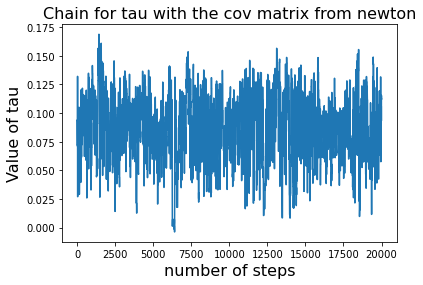

In [82]:
plt.title("Chain for tau with the cov matrix from newton", fontsize= 16)
plt.xlabel("number of steps", fontsize = 16)
plt.ylabel("Value of tau", fontsize=16)
plt.plot(chain3)

We see that the chain oscillates about one value and does not wander off. This means that the chain has has converged

In [83]:
print("Parameters given by the mcmc")
print("H0 =", pars[0], "+/-", error[0])
print("omh2 =", pars[1], "+/-", error[1])
print("omch2 =", pars[2], "+/-", error[2])
print("tau =", pars[3], "+/-", error[3])
print("As =", pars[4], "+/-", error[4])
print("ns =", pars[5], "+/-", error[5])

Parameters given by the mcmc
H0 = 68.348256525103 +/- 0.0075806759129098435
omh2 = 0.022351503254201308 +/- 1.655187315161518e-06
omch2 = 0.11740554230237912 +/- 1.6185176012700788e-05
tau = 0.0853650496499402 +/- 0.0002097223743265108
As = 2.220842282480639e-09 +/- 8.824630998696486e-13
ns = 0.9740768880149552 +/- 4.07594619545541e-05


In [57]:
matiere_obscure, erreur = dark_energy(pars,error)
print("$\Omega_{\lamda}$=", matiere_obscure, "+/-", erreur)

$\Omega_{\lamda}$= 0.7008294570418214 +/- 3.7542607530781973e-06


Q4

In [74]:
chain = np.loadtxt("chain_FirstRun.csv")
chisq = np.loadtxt("chisq_FirstRun.csv")

So first let's do the importance sampling. To re-weigh, I am going to use a gaussian distribution with a mean about 0.054 and a sigma of 0.0074. I mulitply the chisq by the probability of the tau at each sample using the gaussian distro.

In [75]:
w = chisq*gaussian(chain[0:,3], 0.054,0.0074)

pars = np.empty(6)
error = np.empty(6)
n = len(spec)
for i in range(len(pars)):
    pars[i] = np.average(chain[0:,i], weights=w)
    error[i] = weighted_std(chain[0:,i],w)/np.sqrt(n)
 

cov = np.cov(chain.T, aweights=w)

In [76]:
print("Parameters given by importance sampling")
print("H0 =", pars[0], "+/-", error[0])
print("omh2 =", pars[1], "+/-", error[1])
print("omch2 =", pars[2], "+/-", error[2])
print("tau =", pars[3], "+/-", error[3])
print("As =", pars[4], "+/-", error[4])
print("ns =", pars[5], "+/-", error[5])

Parameters given by importance sampling
H0 = 67.89742146356934 +/- 0.01801458842996495
omh2 = 0.022296154798489586 +/- 4.547847837653612e-06
omch2 = 0.11837196183345552 +/- 3.841209778909705e-05
tau = 0.055909991941516475 +/- 0.00014092968159653413
As = 2.096284118154914e-09 +/- 6.015462803469602e-13
ns = 0.971347383243812 +/- 9.089352214724177e-05


Using the importance sampling we get a value on tau much closer to the 0.054 than with a equal weights average

In [31]:
#chain, chisq = mcmc(constraint_chi_sq,pars,cov,spec,errs)

In [32]:
#np.savetxt("chain_NewConstraint.csv", chain)
#np.savetxt("chisq_NewConstrain.csv", chisq)

In [77]:
chain = np.loadtxt("chain_NewConstraint.csv")
chisq = np.loadtxt("chisq_NewConstrain.csv")

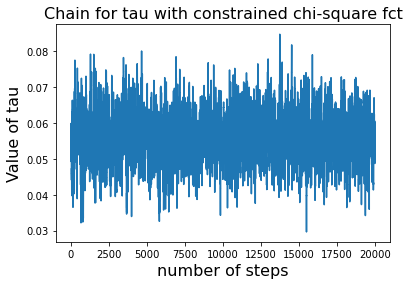

In [78]:
plt.title("Chain for tau with constrained chi-square fct", fontsize= 16)
plt.xlabel("number of steps", fontsize = 16)
plt.ylabel("Value of tau", fontsize=16)
plt.plot(chain[:,3])

In [79]:
pars = np.empty(6)
error = np.empty(6)
denominator = np.sqrt(len(spec))
for i in range(len(pars)):
    pars[i] = np.average(chain[0:,i])
    error[i] = np.std(chain[0:,i])/denominator

In [80]:
print("Parameters given by constrained ")
print("H0 =", pars[0], "+/-", error[0])
print("omh2 =", pars[1], "+/-", error[1])
print("omch2 =", pars[2], "+/-", error[2])
print("tau =", pars[3], "+/-", error[3])
print("As =", pars[4], "+/-", error[4])
print("ns =", pars[5], "+/-", error[5])

Parameters given by constrained 
H0 = 67.72246602873166 +/- 0.019411267072316444
omh2 = 0.022289497112099634 +/- 4.276093498624061e-06
omch2 = 0.11884210031908733 +/- 4.3721039946382435e-05
tau = 0.056046795156113306 +/- 0.00014147867752628627
As = 2.099679828289975e-09 +/- 6.148554549033055e-13
ns = 0.9700726926016747 +/- 0.00010703638526056257
